# EDA: Swire Coca - Cola
## Griffin Brown
9/4/24

This file serves as my personal EDA for the IWC Work Orders.

## Data Loading

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.cloud import storage
import os
from io import StringIO

In [91]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [92]:
'''

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "swire-capstone-2024-0b05c28274b1.json"

STORAGE_BUCKET = 'swire-provided-data'

storage_client = storage.Client()
bucket = storage_client.bucket(STORAGE_BUCKET)

file_path_in_bucket = 'IWC_Work_Orders_Extract.csv'

blob = bucket.blob(file_path_in_bucket)

# Download the file content as a string
csv_data = blob.download_as_string()

# Use StringIO to convert the string data to a file-like object for pandas
df = pd.read_csv(StringIO(csv_data.decode('utf-8')), low_memory=False)

# Display the DataFrame or process it further
print(df.head())

'''

'\n\nos.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "swire-capstone-2024-0b05c28274b1.json"\n\nSTORAGE_BUCKET = \'swire-provided-data\'\n\nstorage_client = storage.Client()\nbucket = storage_client.bucket(STORAGE_BUCKET)\n\nfile_path_in_bucket = \'IWC_Work_Orders_Extract.csv\'\n\nblob = bucket.blob(file_path_in_bucket)\n\n# Download the file content as a string\ncsv_data = blob.download_as_string()\n\n# Use StringIO to convert the string data to a file-like object for pandas\ndf = pd.read_csv(StringIO(csv_data.decode(\'utf-8\')), low_memory=False)\n\n# Display the DataFrame or process it further\nprint(df.head())\n\n'

In [93]:
# for local file

df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


In [94]:
df.shape

(1427264, 25)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

## Data Cleaning

### Dates

In [96]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

### Times

In [97]:
df['ACTUAL_START_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_START_TIME'], errors='coerce')
df['ACTUAL_FINISH_TIME'] = pd.to_datetime('1900-01-01 ' + df['ACTUAL_FINISH_TIME'], errors='coerce')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   ORDER_ID                         1427264 non-null  int64         
 1   PLANT_ID                         1427264 non-null  object        
 2   PRODUCTION_LOCATION              1427264 non-null  object        
 3   EXECUTION_START_DATE             1427264 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            1427264 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                1427264 non-null  datetime64[ns]
 6   ACTUAL_FINISH_TIME               1427264 non-null  datetime64[ns]
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64       
 8   MAINTENANCE_PLAN                 152594 non-null   object        
 9   MAINTENANCE_ITEM                 152594 non-null   float64       
 10  MAINTENANCE_ACTIVITY_TYPE     

### Basic Stats

In [98]:
df.nunique()

ORDER_ID                           1427244
PLANT_ID                                 6
PRODUCTION_LOCATION                      6
EXECUTION_START_DATE                  2956
EXECUTION_FINISH_DATE                 2956
ACTUAL_START_TIME                    65927
ACTUAL_FINISH_TIME                   61388
ACTUAL_WORK_IN_MINUTES                4801
MAINTENANCE_PLAN                      3308
MAINTENANCE_ITEM                      4021
MAINTENANCE_ACTIVITY_TYPE                2
ORDER_DESCRIPTION                   118925
MAINTENANCE_TYPE_DESCRIPTION             5
FUNCTIONAL_LOC                         667
FUNCTIONAL_AREA_NODE_1_MODIFIED          7
FUNCTIONAL_AREA_NODE_2_MODIFIED         67
FUNCTIONAL_AREA_NODE_3_MODIFIED        141
FUNCTIONAL_AREA_NODE_4_MODIFIED         86
FUNCTIONAL_AREA_NODE_5_MODIFIED         36
EQUIPMENT_ID                          2956
EQUIPMENT_DESC                         807
EQUIP_CAT_DESC                           4
EQUIP_START_UP_DATE                     92
EQUIP_VALID

In [99]:
count_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].count()

count_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned       150387
Unplanned    1276877
Name: ACTUAL_WORK_IN_MINUTES, dtype: int64

In [100]:
avg_by_plan = df.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].mean()

avg_by_plan

MAINTENANCE_ACTIVITY_TYPE
Planned      48.034311
Unplanned    93.410893
Name: ACTUAL_WORK_IN_MINUTES, dtype: float64

## EDA

### Timeframes

In [101]:
min_date = df['EXECUTION_START_DATE'].min()
max_date = df['EXECUTION_FINISH_DATE'].max()

time_diff = max_date - min_date

time_diff_years = round((time_diff.days / 365.25), 2)

print(f'Timeframe:', time_diff_years, 'years')

Timeframe: 11.03 years


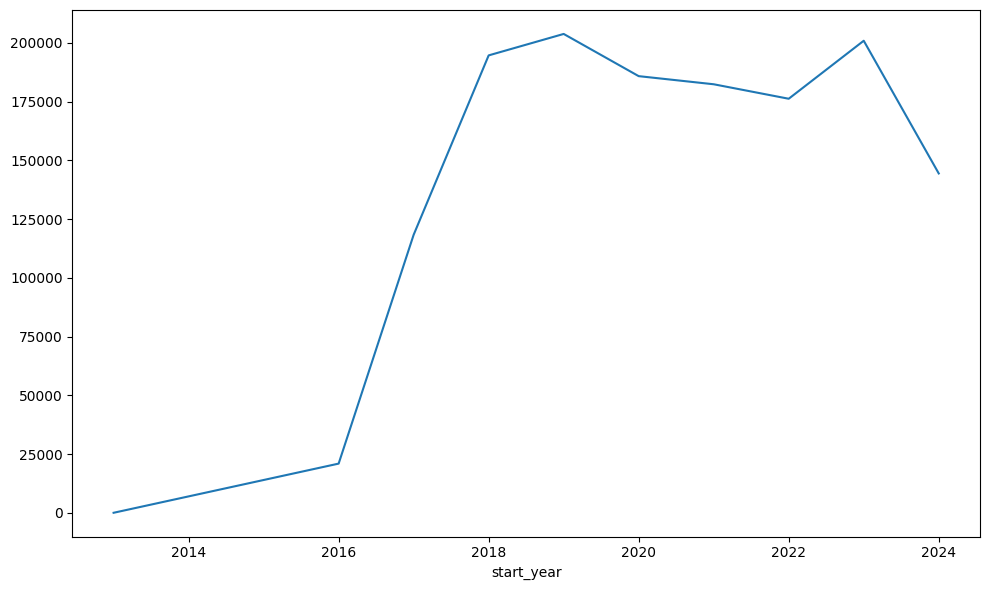

In [102]:
df['start_year'] = df['EXECUTION_START_DATE'].dt.year

count_by_year = df.groupby('start_year').size()

plt.figure(figsize=(10, 6))
count_by_year.plot(kind='line')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

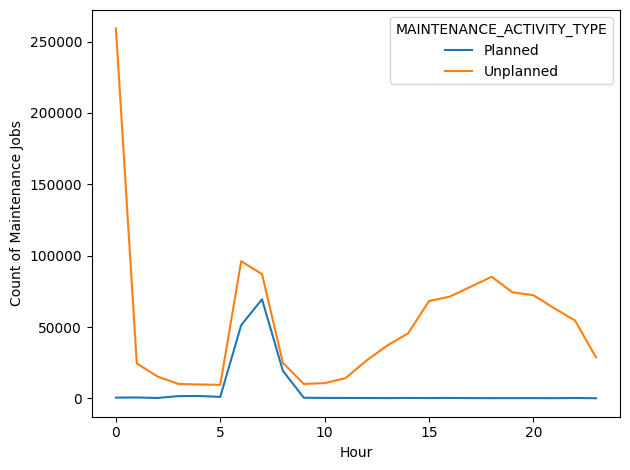

In [103]:
df['hour_start'] = df['ACTUAL_START_TIME'].dt.hour
count_by_hour_type = df.groupby(['hour_start','MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10,6))
count_by_hour_type.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

### Maintenance Activity Type

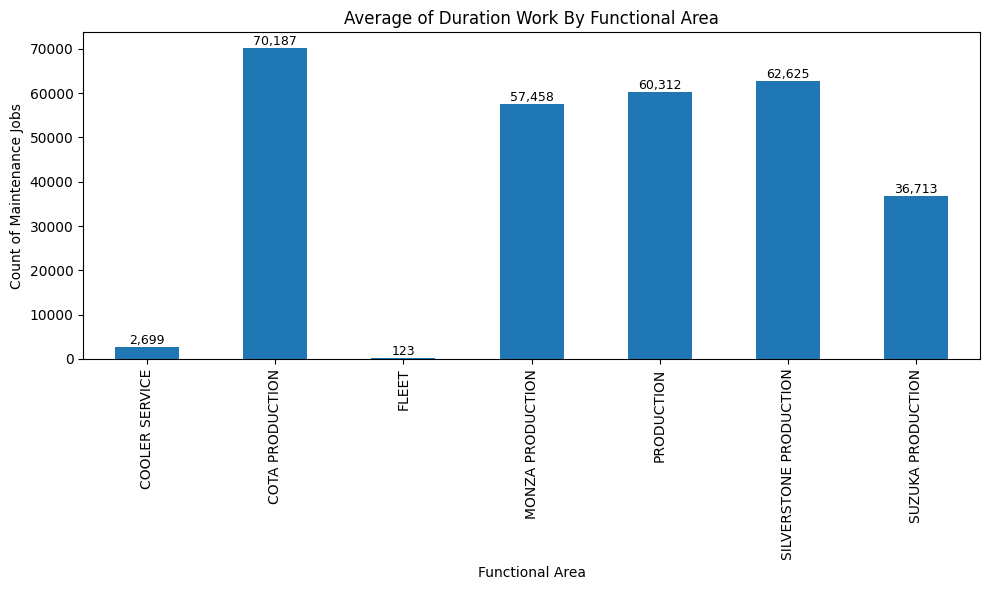

In [104]:
count_by_functional_area = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].count()

plt.figure(figsize=(10, 6))
count_by_functional_area.plot(kind='bar')
plt.title('Average of Duration Work By Functional Area')
for i, value in enumerate(count_by_functional_area):
    plt.text(i, value, f'{value:,.0f}', fontsize=9, ha='center', va='bottom')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Functional Area')
plt.tight_layout()
plt.show()

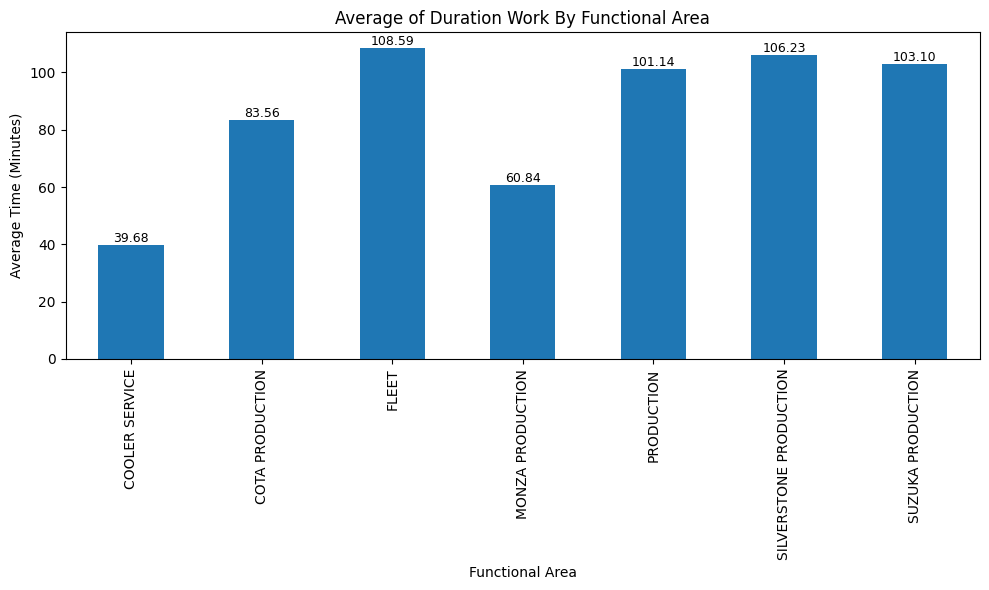

In [105]:
avg_by_functional_area = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].mean()

plt.figure(figsize=(10, 6))
avg_by_functional_area.plot(kind='bar')
plt.title('Average of Duration Work By Functional Area')
for i, value in enumerate(avg_by_functional_area):
    plt.text(i, value, f'{value:.2f}', fontsize=9, ha='center', va='bottom')
plt.ylabel('Average Time (Minutes)')
plt.xlabel('Functional Area')
plt.tight_layout()
plt.show()

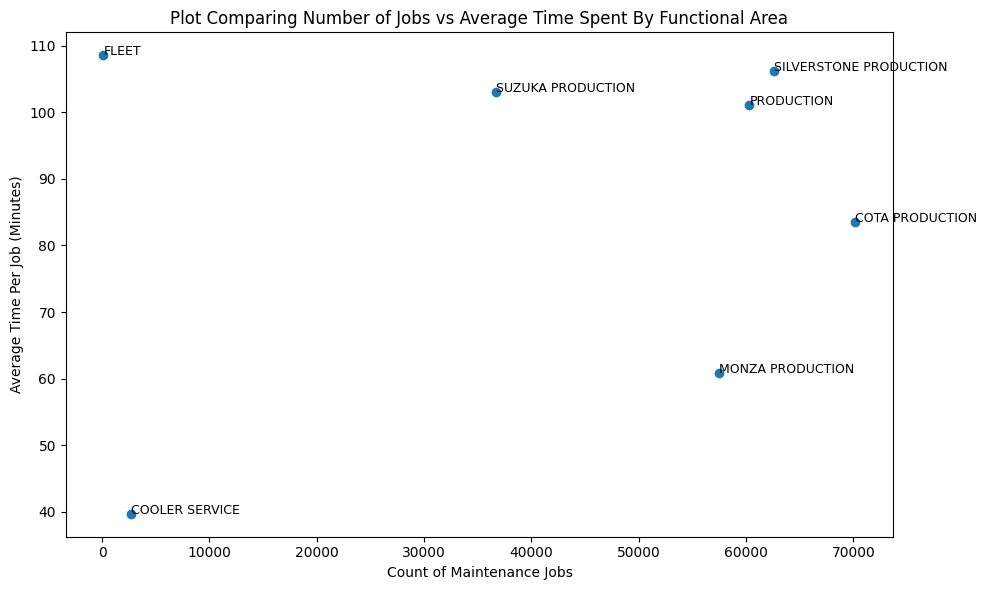

In [106]:
count_x = df['FUNCTIONAL_AREA_NODE_1_MODIFIED'].value_counts()
count_y = df.groupby('FUNCTIONAL_AREA_NODE_1_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].mean()

merged_counts = pd.DataFrame({'occurences': count_x, 'average_time': count_y})

plt.figure(figsize=(10,6))
plt.scatter(merged_counts['occurences'], merged_counts['average_time'])
for i, value in merged_counts.iterrows():
    plt.text(value['occurences'], value['average_time'], str(i), fontsize=9, ha='left')
plt.xlabel('Count of Maintenance Jobs')
plt.ylabel('Average Time Per Job (Minutes)')
plt.title('Plot Comparing Number of Jobs vs Average Time Spent By Functional Area')
plt.tight_layout()
plt.show()

## Time For Parts

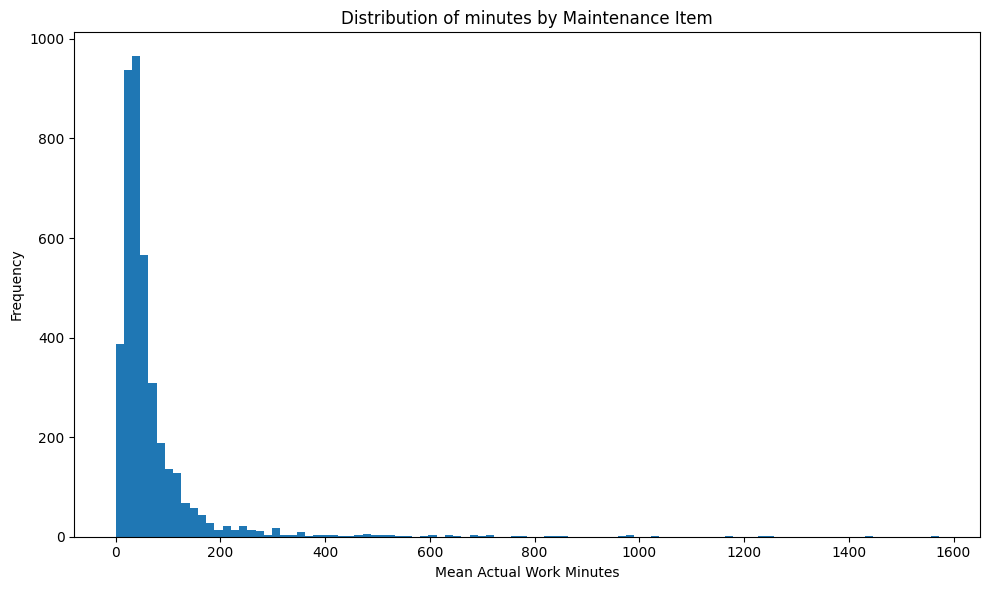

In [107]:
mean_minutes_by_maintenance_item = df.groupby('MAINTENANCE_ITEM')['ACTUAL_WORK_IN_MINUTES'].mean()

plt.figure(figsize=(10,6))
plt.hist(mean_minutes_by_maintenance_item, bins=100)
plt.title("Distribution of minutes by Maintenance Item")
plt.xlabel("Mean Actual Work Minutes")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

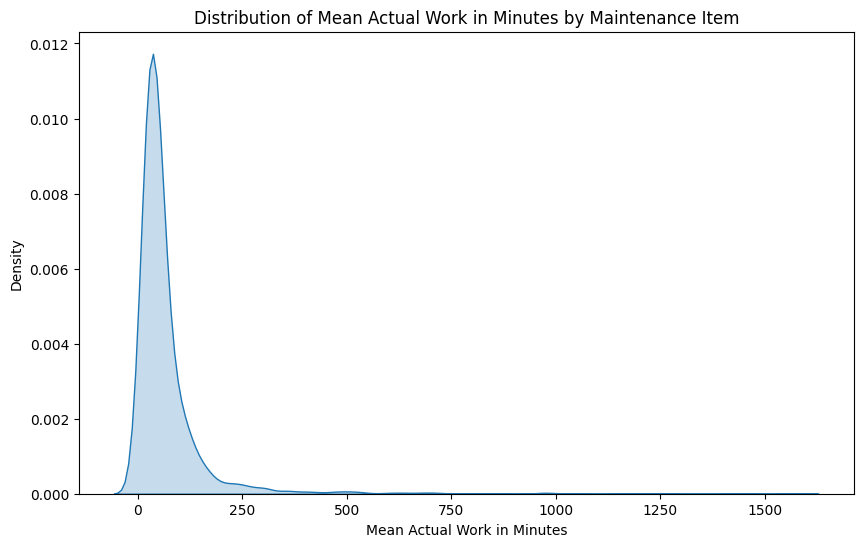

In [108]:
import seaborn as sns

# Plot a KDE (Kernel Density Estimate) of the mean values
plt.figure(figsize=(10, 6))
sns.kdeplot(mean_minutes_by_maintenance_item, fill=True)
plt.title('Distribution of Mean Actual Work in Minutes by Maintenance Item')
plt.xlabel('Mean Actual Work in Minutes')
plt.ylabel('Density')

# Display the plot
plt.show()

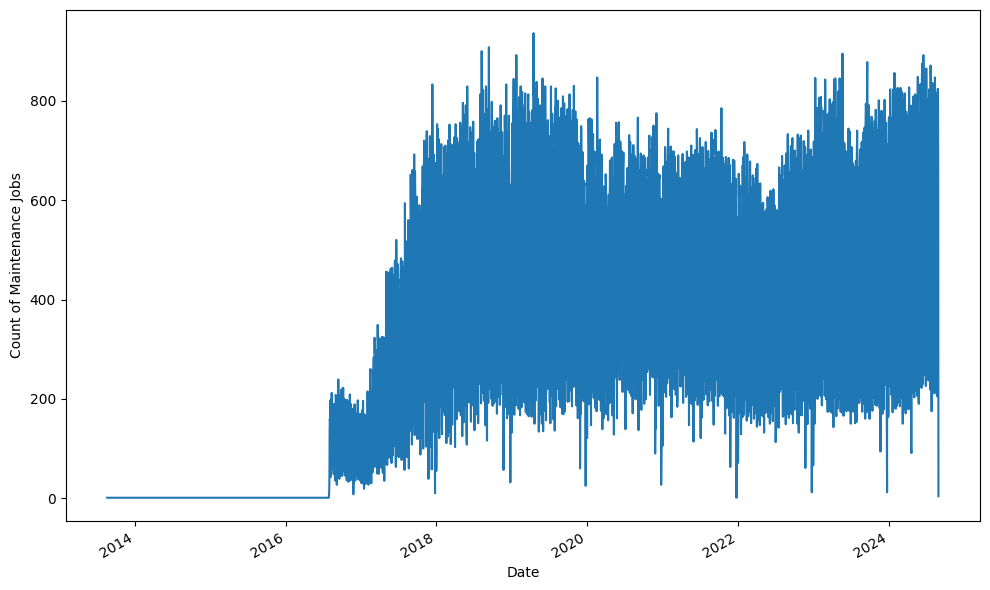

In [109]:
jobs_by_day = df.groupby("EXECUTION_START_DATE").size()

plt.figure(figsize=(10,6))
jobs_by_day.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Date')
plt.tight_layout()
plt.show()




<Figure size 1000x600 with 0 Axes>

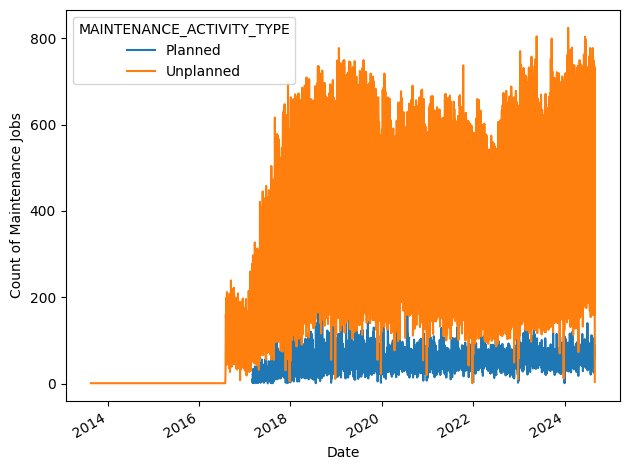

In [110]:
jobs_by_day_type = df.groupby(['EXECUTION_START_DATE','MAINTENANCE_ACTIVITY_TYPE']).size().unstack()

plt.figure(figsize=(10,6))
jobs_by_day_type.plot(kind='line')
plt.ylabel('Count of Maintenance Jobs')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


## Count by Parts

In [111]:
count_by_part = df.groupby('EQUIPMENT_DESC').size().sort_values(ascending=False).reset_index(name='Count')

count_by_part

,EQUIPMENT_DESC,Count
0,L1 FILLER_ROTARY_CAN_72_VALVE,3745
1,L1 FILLER_ROTARY_BTL_60_VALVE,2738
2,L4 FILLER_ROTARY_CAN_100_VALVE,2511
3,L2 FILLER_ROTARY_BTL_45_VALVE,2072
4,L3 LABELER_ROTARY,1955
...,...,...
802,ALLIANCE - M16 90 AFTER MAIN INCLINE,1
803,L2 CASE DROP CHUTE,1
804,CONV_CBL_EMPTY_CAN,1
805,L10 WRAPPER_STRETCH_LANTECH_EAST,1


In [112]:
count_by_part.to_csv('part_list.csv')

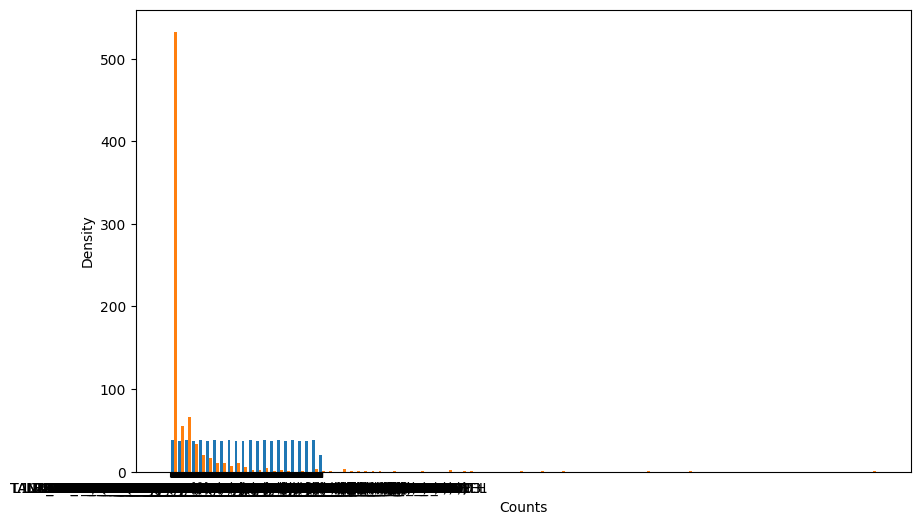

In [113]:
plt.figure(figsize=(10, 6))
plt.hist(count_by_part, bins=100)
#plt.title('Distribution of Mean Actual Work in Minutes by Maintenance Item')
plt.xlabel('Counts')
plt.ylabel('Density')

# Display the plot
plt.show()

In [114]:
avg_work_part =  df.groupby('EQUIPMENT_DESC').agg(
    count=('EQUIPMENT_DESC', 'size'),
    avg_work_time=('ACTUAL_WORK_IN_MINUTES', 'mean')
).sort_values(by='count', ascending=False).reset_index()

avg_work_part

,EQUIPMENT_DESC,count,avg_work_time
0,L1 FILLER_ROTARY_CAN_72_VALVE,3745,88.618798
1,L1 FILLER_ROTARY_BTL_60_VALVE,2738,64.620964
2,L4 FILLER_ROTARY_CAN_100_VALVE,2511,79.103226
3,L2 FILLER_ROTARY_BTL_45_VALVE,2072,115.329151
4,L3 LABELER_ROTARY,1955,42.938210
...,...,...,...
802,ALLIANCE - M16 90 AFTER MAIN INCLINE,1,840.000000
803,L2 CASE DROP CHUTE,1,0.600000
804,CONV_CBL_EMPTY_CAN,1,720.000000
805,L10 WRAPPER_STRETCH_LANTECH_EAST,1,24.000000


In [115]:
count_bins=[0,1,100,500,4000]
avg_work_part['binned'] = pd.cut(avg_work_part['count'], count_bins)

avg_work_part

,EQUIPMENT_DESC,count,avg_work_time,binned
0,L1 FILLER_ROTARY_CAN_72_VALVE,3745,88.618798,"(500, 4000]"
1,L1 FILLER_ROTARY_BTL_60_VALVE,2738,64.620964,"(500, 4000]"
2,L4 FILLER_ROTARY_CAN_100_VALVE,2511,79.103226,"(500, 4000]"
3,L2 FILLER_ROTARY_BTL_45_VALVE,2072,115.329151,"(500, 4000]"
4,L3 LABELER_ROTARY,1955,42.938210,"(500, 4000]"
...,...,...,...,...
802,ALLIANCE - M16 90 AFTER MAIN INCLINE,1,840.000000,"(0, 1]"
803,L2 CASE DROP CHUTE,1,0.600000,"(0, 1]"
804,CONV_CBL_EMPTY_CAN,1,720.000000,"(0, 1]"
805,L10 WRAPPER_STRETCH_LANTECH_EAST,1,24.000000,"(0, 1]"


In [116]:
avg_work_part.groupby('binned').agg(
    total_count=('count', 'sum'),
    avg_time=('avg_work_time', 'mean'),
    median_time=('avg_work_time', 'median')
)

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_52263/932642431.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_work_part.groupby('binned').agg(


,total_count,avg_time,median_time
binned,,,
"(0, 1]",154,155.244156,90.000000
"(1, 100]",10958,119.227716,90.000000
"(100, 500]",28532,67.625682,51.543323
"(500, 4000]",39803,70.337952,63.713924


In [117]:
df[df['EQUIPMENT_DESC'] == 'L1 FILLER_ROTARY_CAN_72_VALVE'].groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'EXECUTION_START_DATE']).size()

PRODUCTION_LOCATION  FUNCTIONAL_AREA_NODE_3_MODIFIED  EXECUTION_START_DATE
COTA                 LINE #1-CAN_LINE                 2019-10-06              1
                                                      2019-10-07              1
                                                      2019-10-11              6
                                                      2019-10-12              2
                                                      2019-10-13              2
                                                                             ..
                                                      2024-08-25              1
                                                      2024-08-26              8
                                                      2024-08-27              6
                                                      2024-08-28              4
                                                      2024-08-29              2
Length: 1355, dtype: int64

In [118]:
import re

df['EQUIPMENT_DESC'] = df['EQUIPMENT_DESC'].astype(str)

# Define a function to strip numbers and anything between parentheses
def strip_numbers_and_parentheses(equipment_desc):
    # Remove anything in parentheses
    equipment_desc = re.sub(r'\(.*?\)', '', equipment_desc)
    # Remove numbers
    equipment_desc = re.sub(r'\d+', '', equipment_desc)

    equipment_desc = equipment_desc.replace('_', '')
    # Remove extra whitespace that may result from stripping
    equipment_desc = equipment_desc.strip()
    return equipment_desc

# Apply the function to strip numbers and parentheses
df['CLEANED_EQUIPMENT_DESC'] = df['EQUIPMENT_DESC'].apply(strip_numbers_and_parentheses)

In [119]:
df.groupby(['EQUIPMENT_DESC', 'CLEANED_EQUIPMENT_DESC']).size().sort_values()


EQUIPMENT_DESC                  CLEANED_EQUIPMENT_DESC  
L10 WATER HEATER-ARMSTRONG      L WATER HEATER-ARMSTRONG          1
FULL CAN CONVEYOR (FC50)        FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC49)        FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC45D)       FULL CAN CONVEYOR                 1
FULL CAN CONVEYOR (FC45C)       FULL CAN CONVEYOR                 1
                                                             ...   
L2 FILLER_ROTARY_BTL_45_VALVE   L FILLERROTARYBTLVALVE         2072
L4 FILLER_ROTARY_CAN_100_VALVE  L FILLERROTARYCANVALVE         2511
L1 FILLER_ROTARY_BTL_60_VALVE   L FILLERROTARYBTLVALVE         2738
L1 FILLER_ROTARY_CAN_72_VALVE   L FILLERROTARYCANVALVE         3745
nan                             nan                         1347817
Length: 808, dtype: int64

In [120]:
df.groupby('CLEANED_EQUIPMENT_DESC').size().sort_values(ascending=False)

CLEANED_EQUIPMENT_DESC
nan                                1347817
L FILLERROTARYCANVALVE                7010
L FILLERROTARYBTLVALVE                6284
L LABELERROTARY                       2583
L PACKRCASEWESTROCKDDM                2093
                                    ...   
PUMPCENTSANITFILLERRETURN L              1
PUMPCENTSANITDISCHARGE L                 1
PUMPCENTSANITBLENDTANK L                 1
PUMPCENTSANIT                            1
L DOMINO LASER CAN CODER - EAST          1
Length: 569, dtype: int64

In [124]:
df.groupby(df['FUNCTIONAL_LOC'].str.len()).size()

FUNCTIONAL_LOC
8.0       7877
12.0     23853
16.0     21126
20.0        27
21.0    236669
25.0       301
26.0      1929
dtype: int64

In [125]:
#df['average_life'] = df

In [126]:
# Group by PLANT_ID, FUNCTIONAL_AREA_NODE_3_MODIFIED, and EQUIPMENT_ID
grouped_df = df.groupby(['PLANT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'EQUIPMENT_ID'])

# Calculate the time difference between the earliest EXECUTION_START_DATE and the latest EXECUTION_FINISH_DATE for each group
df['TIME_BETWEEN_START_AND_FINISH'] = (df['EXECUTION_FINISH_DATE'] - df['EXECUTION_START_DATE']).dt.days

# For each group, find the time span between the first execution start date and the last execution finish date
time_span_by_group = grouped_df.agg(
    FIRST_EXECUTION_START=pd.NamedAgg(column='EXECUTION_START_DATE', aggfunc='min'),
    LAST_EXECUTION_FINISH=pd.NamedAgg(column='EXECUTION_FINISH_DATE', aggfunc='max')
)

# Calculate the duration (in days) between the first execution start and the last execution finish
time_span_by_group['TIME_SPAN_IN_DAYS'] = (time_span_by_group['LAST_EXECUTION_FINISH'] - time_span_by_group['FIRST_EXECUTION_START']).dt.days

# Reset the index for easier reading
time_span_by_group = time_span_by_group.reset_index()


In [127]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,start_year,hour_start,CLEANED_EQUIPMENT_DESC,TIME_BETWEEN_START_AND_FINISH
0,705642457,G812,ROMA,2024-05-04,2024-05-12,1900-01-01 06:00:00,1900-01-01 23:04:08,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2024,6,FULL CAN CONVEYOR,8
1,704191697,G812,ROMA,2022-09-13,2022-09-13,1900-01-01 06:00:00,1900-01-01 17:17:24,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022,6,FULL CAN CONVEYOR,0
2,704466547,G812,ROMA,2022-12-21,2022-12-21,1900-01-01 07:00:00,1900-01-01 07:00:00,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022,7,FULL CAN CONVEYOR,0
3,703834477,G812,ROMA,2022-07-04,2022-07-04,1900-01-01 06:00:00,1900-01-01 06:00:00,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022,6,FULL CAN CONVEYOR,0
4,704661125,G291,MONZA,2023-03-15,2023-03-15,1900-01-01 07:00:00,1900-01-01 07:00:00,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,NaT,2023,7,TANKSTLSTORAIR,0


In [128]:
example_time_diff = df[df['FUNCTIONAL_LOC'] == 'G812-PRD-L15-L03-L030-020'].sort_values('EXECUTION_START_DATE')

In [129]:
selected_columns = ['ORDER_ID', 'PLANT_ID', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIPMENT_ID', 'EQUIPMENT_DESC', 'TIME_BETWEEN_START_AND_FINISH']
filtered_selected_df = example_time_diff[selected_columns]

In [130]:
filtered_selected_df.head()

,ORDER_ID,PLANT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,EQUIPMENT_ID,EQUIPMENT_DESC,TIME_BETWEEN_START_AND_FINISH
229859,702712501,G812,G812-PRD-L15-L03-L030-020,2021-01-16,2021-01-16,300126836.0,FULL CAN CONVEYOR (FC60),0
1065751,702711538,G812,G812-PRD-L15-L03-L030-020,2021-01-16,2021-01-16,300126811.0,FULL CAN CONVEYOR (FC41A),0
1383307,702764911,G812,G812-PRD-L15-L03-L030-020,2021-02-10,2021-02-10,300126814.0,FULL CAN CONVEYOR (FC43),0
1065754,703036469,G812,G812-PRD-L15-L03-L030-020,2021-06-24,2021-06-24,300126811.0,FULL CAN CONVEYOR (FC41A),0
1065748,703141582,G812,G812-PRD-L15-L03-L030-020,2021-11-23,2022-01-18,300126811.0,FULL CAN CONVEYOR (FC41A),56


## Table Development

### By Line

In [131]:
selected_columns = ['PLANT_ID', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']

df[selected_columns].sort_values(selected_columns)

,PLANT_ID,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE
1284117,G221,300009071.0,2017-05-08,2017-05-08
222682,G221,300009071.0,2017-06-20,2017-06-20
1015712,G221,300009071.0,2017-07-17,2017-07-17
707006,G221,300009071.0,2017-10-10,2017-10-10
1196118,G221,300009071.0,2017-11-14,2017-12-13
...,...,...,...,...
1229459,G816,NaN,2024-08-29,2024-08-29
1389477,G816,NaN,2024-08-29,2024-08-29
1395410,G816,NaN,2024-08-29,2024-08-29
1415264,G816,NaN,2024-08-29,2024-08-29


In [169]:
selected_columns = ['PLANT_ID', 'EQUIPMENT_ID', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']


# filter rows with count of only 1
df_filtered = df.groupby('EQUIPMENT_ID').filter(lambda x: len(x) > 1)[selected_columns]

# Sort by PLANT_ID, EQUIPMENT_ID, and EXECUTION_START_DATE
df_sorted = df_filtered.sort_values(['PLANT_ID', 'FUNCTIONAL_LOC', 'EQUIPMENT_ID', 'EXECUTION_START_DATE'])

# Group by PLANT_ID and EQUIPMENT_ID
df_sorted['PREV_EXECUTION_FINISH_DATE'] = df_sorted.groupby(['PLANT_ID', 'FUNCTIONAL_LOC', 'EQUIPMENT_ID'])['EXECUTION_FINISH_DATE'].shift(1)

# Calculate the time difference (life) in days between consecutive EXECUTION_START_DATE and the previous EXECUTION_FINISH_DATE
df_sorted['LIFE'] = (df_sorted['EXECUTION_START_DATE'] - df_sorted['PREV_EXECUTION_FINISH_DATE']).dt.days

# Replace NaN with 0 for the first occurrence
df_sorted['LIFE'] = df_sorted['LIFE'].fillna(pd.NA)

# Select relevant columns
result = df_sorted[['PLANT_ID', 'EQUIPMENT_ID', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES', 'LIFE']]

# Calculate the average time between execution start and finish for each PLANT_ID and EQUIPMENT_ID
#average_life = result.groupby(['PLANT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'EQUIPMENT_ID'])['LIFE'].mean().reset_index(name='AVERAGE_LIFE')

average_life = result.groupby(['PLANT_ID', 'FUNCTIONAL_LOC', 'EQUIPMENT_ID']).agg(
        MEAN_LIFESPAN=('LIFE', 'mean'),
        MEAN_TIME_MAINTENENCE=('ACTUAL_WORK_IN_MINUTES', 'mean')
    )

In [170]:
average_life.head()

MEAN_LIFESPAN  MEAN_TIME_MAINTENENCE
PLANT_ID FUNCTIONAL_LOC   EQUIPMENT_ID                                      
G221     G221-CLR-A85-E06 300009603.0        1.788656              43.255870
                          300009623.0       83.935484              34.143750
                          300009624.0        2.252534              35.351899
         G221-PRD         300009149.0       42.783333             249.629508
                          300245200.0       93.000000             103.400000

In [171]:
average_life.size

5692

In [179]:
df_lifespan = pd.merge(df_sorted, average_life, on=['FUNCTIONAL_LOC'], how='left')

df_lifespan.head()

,PLANT_ID,EQUIPMENT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,PREV_EXECUTION_FINISH_DATE,LIFE,MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE
0,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,1.788656,43.255870
1,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,83.935484,34.143750
2,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,2.252534,35.351899
3,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,45.0,2017-05-08,0.0,1.788656,43.255870
4,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,45.0,2017-05-08,0.0,83.935484,34.143750


In [180]:
df_lifespan.size

20877460

In [175]:
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = (df_lifespan['EXECUTION_FINISH_DATE'] + pd.to_timedelta(df_lifespan['MEAN_LIFESPAN'], unit='D')).dt.date

In [176]:
df_lifespan.head()

,PLANT_ID,EQUIPMENT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,PREV_EXECUTION_FINISH_DATE,LIFE,MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE,EXPECTED_MAINTENANCE_DATE
0,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,1.788656,43.25587,2017-05-09
1,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,45.0,2017-05-08,0.0,1.788656,43.25587,2017-05-09
2,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,30.0,2017-05-08,0.0,1.788656,43.25587,2017-05-09
3,G221,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,60.0,2017-05-08,0.0,1.788656,43.25587,2017-05-09
4,G221,300009603.0,G221-CLR-A85-E06,2017-05-15,2017-05-15,30.0,2017-05-08,7.0,1.788656,43.25587,2017-05-16


In [178]:
df_lifespan['FUNCTIONAL_LOC'].unique

<bound method Series.unique of 0         G221-CLR-A85-E06
1         G221-CLR-A85-E06
2         G221-CLR-A85-E06
3         G221-CLR-A85-E06
4         G221-CLR-A85-E06
                ...       
291372                 NaN
291373                 NaN
291374                 NaN
291375                 NaN
291376                 NaN
Name: FUNCTIONAL_LOC, Length: 291377, dtype: object>

In [168]:
df[df['EQUIPMENT_DESC'].notna()].size

41390656

### By Functional Location

In [182]:
selected_columns = ['EQUIPMENT_ID', 'FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']


# filter rows with count of only 1
df_filtered = df.groupby('EQUIPMENT_ID').filter(lambda x: len(x) > 1)[selected_columns]

# Sort by PLANT_ID, EQUIPMENT_ID, and EXECUTION_START_DATE
df_sorted = df_filtered.sort_values(['FUNCTIONAL_LOC', 'EQUIPMENT_ID', 'EXECUTION_START_DATE'])

# Group by PLANT_ID and EQUIPMENT_ID
df_sorted['PREV_EXECUTION_FINISH_DATE'] = df_sorted.groupby(['FUNCTIONAL_LOC'])['EXECUTION_FINISH_DATE'].shift(1)

# Calculate the time difference (life) in days between consecutive EXECUTION_START_DATE and the previous EXECUTION_FINISH_DATE
df_sorted['LIFE'] = (df_sorted['EXECUTION_START_DATE'] - df_sorted['PREV_EXECUTION_FINISH_DATE']).dt.days

# Replace NaN with 0 for the first occurrence
df_sorted['LIFE'] = df_sorted['LIFE'].fillna(pd.NA)

# Select relevant columns
result = df_sorted[['FUNCTIONAL_LOC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES', 'LIFE']]

# Calculate the average time between execution start and finish for each PLANT_ID and EQUIPMENT_ID
#average_life = result.groupby(['PLANT_ID', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'EQUIPMENT_ID'])['LIFE'].mean().reset_index(name='AVERAGE_LIFE')

average_life = result.groupby('FUNCTIONAL_LOC').agg(
        MEAN_LIFESPAN=('LIFE', 'mean'),
        MEAN_TIME_MAINTENENCE=('ACTUAL_WORK_IN_MINUTES', 'mean')
)

In [183]:
df_lifespan = pd.merge(df_sorted, average_life, on=['FUNCTIONAL_LOC'], how='left')

In [184]:
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = (df_lifespan['EXECUTION_FINISH_DATE'] + pd.to_timedelta(df_lifespan['MEAN_LIFESPAN'], unit='D')).dt.date

In [185]:
df_lifespan.head()

,EQUIPMENT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,PREV_EXECUTION_FINISH_DATE,LIFE,MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE,EXPECTED_MAINTENANCE_DATE
0,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,0.980726,39.677584,2017-05-08
1,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,45.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08
2,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,30.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08
3,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,60.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08
4,300009603.0,G221-CLR-A85-E06,2017-05-15,2017-05-15,30.0,2017-05-08,7.0,0.980726,39.677584,2017-05-15


In [186]:
df_lifespan.size

2913770

In [187]:
df.size

41390656

In [210]:
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = pd.to_datetime(df_lifespan['EXPECTED_MAINTENANCE_DATE'])

df_lifespan['ACTUAL_NEXT_MAINTENACE'] = pd.to_datetime(df_lifespan.groupby(['FUNCTIONAL_LOC'])['EXECUTION_START_DATE'].shift(-1))
df_lifespan['EXPECTED_DIFFERENCE'] = (df_lifespan['EXPECTED_MAINTENANCE_DATE'] - df_lifespan['ACTUAL_NEXT_MAINTENACE']).dt.days

In [211]:
df_lifespan.head()

,EQUIPMENT_ID,FUNCTIONAL_LOC,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,PREV_EXECUTION_FINISH_DATE,LIFE,MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE,EXPECTED_MAINTENANCE_DATE,ACTUAL_NEXT_MAINTENACE,EXPECTED_DIFFERENCE
0,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,15.0,NaT,NaN,0.980726,39.677584,2017-05-08,2017-05-08,0.0
1,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,45.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08,2017-05-08,0.0
2,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,30.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08,2017-05-08,0.0
3,300009603.0,G221-CLR-A85-E06,2017-05-08,2017-05-08,60.0,2017-05-08,0.0,0.980726,39.677584,2017-05-08,2017-05-15,-7.0
4,300009603.0,G221-CLR-A85-E06,2017-05-15,2017-05-15,30.0,2017-05-08,7.0,0.980726,39.677584,2017-05-15,2017-05-15,0.0


In [219]:
float(df_lifespan['EXPECTED_DIFFERENCE'].mean())

-0.5511963236609293

## TO DO
Add line to df_lifespan ('FUNCTIONAL_AREA_NODE_3_MODIFIED'), then add longest job for a start date on that line. This should provide the opportunity to put jobs under the longest maintenance period.

Optimal total maintenance time: 26083830.52043734
Optimal simulation index: 67


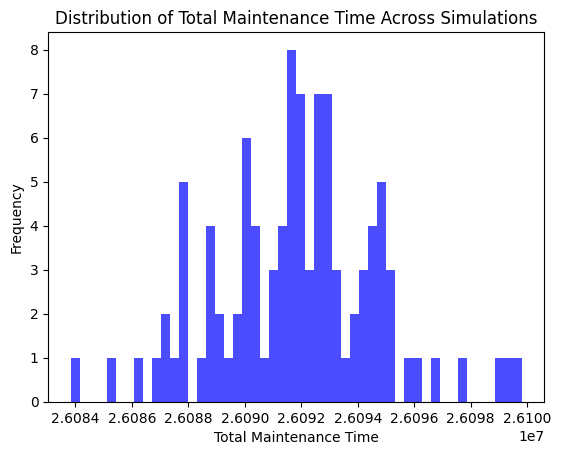

In [224]:
import numpy as np

# Parameters
num_simulations = 100  # Number of Monte Carlo simulations
num_jobs = len(df_lifespan)  # Number of jobs to schedule

# Create a placeholder for the simulation results
sim_results = []

# Monte Carlo simulation loop
for i in range(num_simulations):
    # Simulate the random 'LIFE' and 'MAINTENANCE TIME' for each job
    df_lifespan['SIMULATED_LIFE'] = np.random.normal(df_lifespan['MEAN_LIFESPAN'], 0.2)  # Example: normal distribution with a standard deviation of 0.2
    df_lifespan['SIMULATED_MAINTENANCE_TIME'] = np.random.normal(df_lifespan['MEAN_TIME_MAINTENENCE'], 5)  # Example: normal distribution with a standard deviation of 5
    
    # Simulate start dates based on the simulated life span
    df_lifespan['SIMULATED_START_DATE'] = df_lifespan['EXECUTION_START_DATE'] + pd.to_timedelta(df_lifespan['SIMULATED_LIFE'], unit='D')
    
    # Calculate total downtime (or any other KPI you want to optimize)
    total_maintenance_time = df_lifespan['SIMULATED_MAINTENANCE_TIME'].sum()
    sim_results.append(total_maintenance_time)

# Convert results into a DataFrame
sim_results_df = pd.DataFrame(sim_results, columns=['Total_Maintenance_Time'])

# Analyze the simulation results
optimal_schedule = sim_results_df['Total_Maintenance_Time'].min()  # Example: minimize total maintenance time
optimal_simulation = sim_results_df[sim_results_df['Total_Maintenance_Time'] == optimal_schedule].index[0]

print(f"Optimal total maintenance time: {optimal_schedule}")
print(f"Optimal simulation index: {optimal_simulation}")

# Plot the distribution of total maintenance times
plt.hist(sim_results_df['Total_Maintenance_Time'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Total Maintenance Time Across Simulations')
plt.xlabel('Total Maintenance Time')
plt.ylabel('Frequency')
plt.show()

Optimal total maintenance time: 4651697.127799769
Optimal simulation index: 130


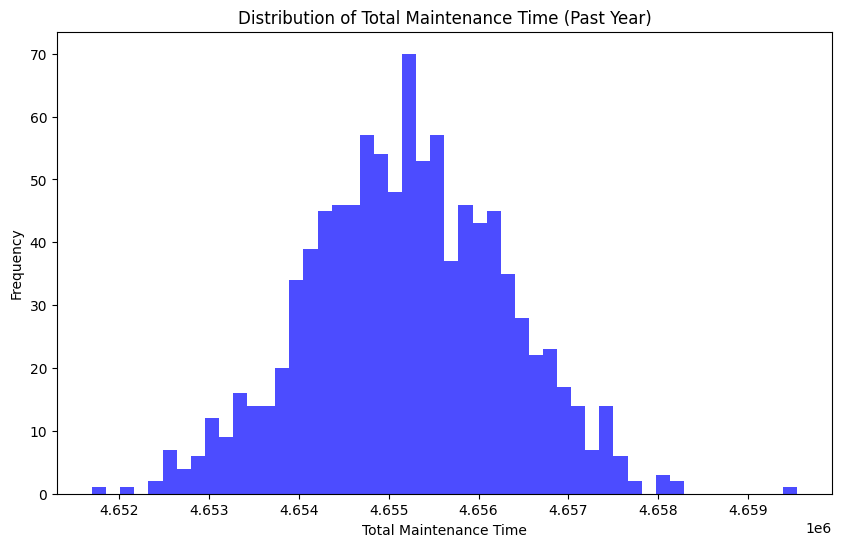

In [223]:
# Define the date range (e.g., simulate the past year)
one_year_ago = pd.Timestamp.today() - pd.DateOffset(years=1)

# Filter the DataFrame to include only jobs from the past year
df_lifespan_filtered = df_lifespan[df_lifespan['EXECUTION_START_DATE'] >= one_year_ago].copy()

# Parameters
num_simulations = 1000  # Number of Monte Carlo simulations
num_jobs = len(df_lifespan_filtered)  # Number of jobs in the past year

# Create a placeholder for the simulation results
sim_results = []

# Monte Carlo simulation loop
for i in range(num_simulations):
    # Simulate the random 'LIFE' and 'MAINTENANCE TIME' for each job in the past year
    df_lifespan_filtered['SIMULATED_LIFE'] = np.random.normal(df_lifespan_filtered['MEAN_LIFESPAN'], 0.2)  # Simulated lifespan
    df_lifespan_filtered['SIMULATED_MAINTENANCE_TIME'] = np.random.normal(df_lifespan_filtered['MEAN_TIME_MAINTENENCE'], 5)  # Simulated maintenance time
    
    # Simulate the next job start dates based on the random 'SIMULATED_LIFE'
    df_lifespan_filtered['SIMULATED_START_DATE'] = df_lifespan_filtered['EXECUTION_START_DATE'] + pd.to_timedelta(df_lifespan_filtered['SIMULATED_LIFE'], unit='D')
    
    # Calculate the total downtime or total maintenance time for each simulation
    total_maintenance_time = df_lifespan_filtered['SIMULATED_MAINTENANCE_TIME'].sum()
    
    # Store the result of this simulation
    sim_results.append(total_maintenance_time)

# Convert results into a DataFrame
sim_results_df = pd.DataFrame(sim_results, columns=['Total_Maintenance_Time'])

# Analyze the simulation results
optimal_schedule = sim_results_df['Total_Maintenance_Time'].min()  # Find the optimal schedule that minimizes total maintenance time
optimal_simulation = sim_results_df[sim_results_df['Total_Maintenance_Time'] == optimal_schedule].index[0]

print(f"Optimal total maintenance time: {optimal_schedule}")
print(f"Optimal simulation index: {optimal_simulation}")

# Plot the distribution of total maintenance times
plt.figure(figsize=(10, 6))
plt.hist(sim_results_df['Total_Maintenance_Time'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Total Maintenance Time (Past Year)')
plt.xlabel('Total Maintenance Time')
plt.ylabel('Frequency')
plt.show()


In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the date range (e.g., simulate the past year)
one_year_ago = pd.Timestamp.today() - pd.DateOffset(years=1)

# Filter the DataFrame to include only jobs from the past year
df_lifespan_filtered = df_lifespan[df_lifespan['EXECUTION_START_DATE'] >= one_year_ago].copy()

# Parameters
num_simulations = 10  # Number of Monte Carlo simulations
num_jobs = len(df_lifespan_filtered)  # Number of jobs in the past year
stacking_threshold_days = 30  # Jobs within 30 days will be stacked

# Create a placeholder for the simulation results
sim_results = []
time_saved_results = []

# Monte Carlo simulation loop
for i in range(num_simulations):
    # Simulate the random 'LIFE' and 'MAINTENANCE TIME' for each job in the past year
    df_lifespan_filtered['SIMULATED_LIFE'] = np.random.normal(df_lifespan_filtered['MEAN_LIFESPAN'], 0.2)  # Simulated lifespan
    df_lifespan_filtered['SIMULATED_MAINTENANCE_TIME'] = np.random.normal(df_lifespan_filtered['MEAN_TIME_MAINTENENCE'], 5)  # Simulated maintenance time
    
    # Simulate the next job start dates based on the random 'SIMULATED_LIFE'
    df_lifespan_filtered['SIMULATED_START_DATE'] = df_lifespan_filtered['EXECUTION_START_DATE'] + pd.to_timedelta(df_lifespan_filtered['SIMULATED_LIFE'], unit='D')
    
    # Sort jobs by FUNCTIONAL_LOC and SIMULATED_START_DATE to group jobs in the same location
    df_lifespan_filtered = df_lifespan_filtered.sort_values(['FUNCTIONAL_LOC', 'SIMULATED_START_DATE'])
    
    # Initialize variables to track total maintenance time and time saved
    total_maintenance_time = 0
    time_saved = 0
    
    # Iterate over each job and stack jobs where possible
    for idx, row in df_lifespan_filtered.iterrows():
        # Check for upcoming jobs in the same FUNCTIONAL_LOC within the next 30 days
        future_jobs = df_lifespan_filtered[
            (df_lifespan_filtered['FUNCTIONAL_LOC'] == row['FUNCTIONAL_LOC']) &
            (df_lifespan_filtered['SIMULATED_START_DATE'] > row['SIMULATED_START_DATE']) &
            (df_lifespan_filtered['SIMULATED_START_DATE'] <= row['SIMULATED_START_DATE'] + pd.Timedelta(days=stacking_threshold_days))
        ]
        
        # Stack future jobs into the current job
        if not future_jobs.empty:
            # Combine the maintenance time of all stacked jobs
            stacked_maintenance_time = row['SIMULATED_MAINTENANCE_TIME'] + future_jobs['SIMULATED_MAINTENANCE_TIME'].sum()
            
            # Save the time difference (stacked jobs are done together, saving time)
            time_saved += future_jobs['SIMULATED_MAINTENANCE_TIME'].sum()
            
            # Remove future jobs (as they are now stacked and handled in the current job)
            df_lifespan_filtered = df_lifespan_filtered.drop(future_jobs.index)
            
            # Update total maintenance time for the stacked jobs
            total_maintenance_time += stacked_maintenance_time
        else:
            # No stacking, add the current job's maintenance time
            total_maintenance_time += row['SIMULATED_MAINTENANCE_TIME']
    
    # Store the result of this simulation
    sim_results.append(total_maintenance_time)
    time_saved_results.append(time_saved)

# Convert results into a DataFrame
sim_results_df = pd.DataFrame({
    'Total_Maintenance_Time': sim_results,
    'Time_Saved': time_saved_results
})

# Analyze the simulation results
optimal_schedule = sim_results_df['Total_Maintenance_Time'].min()  # Find the optimal schedule that minimizes total maintenance time
optimal_simulation = sim_results_df[sim_results_df['Total_Maintenance_Time'] == optimal_schedule].index[0]

print(f"Optimal total maintenance time: {optimal_schedule}")
print(f"Optimal simulation index: {optimal_simulation}")
print(f"Time saved in optimal simulation: {sim_results_df.loc[optimal_simulation, 'Time_Saved']}")

# Plot the distribution of total maintenance times and time saved
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sim_results_df['Total_Maintenance_Time'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Total Maintenance Time (Past Year)')
plt.xlabel('Total Maintenance Time')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sim_results_df['Time_Saved'], bins=50, alpha=0.7, color='green')
plt.title('Distribution of Time Saved by Stacking Jobs')
plt.xlabel('Time Saved (Minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

In [228]:
# Analyze the simulation results
optimal_schedule = sim_results_df['Total_Maintenance_Time'].min()  # Find the optimal schedule that minimizes total maintenance time

# Ensure there are matching rows for the optimal schedule
optimal_simulation_rows = sim_results_df[sim_results_df['Total_Maintenance_Time'] == optimal_schedule]

# Check if there are any rows matching the optimal schedule
if not optimal_simulation_rows.empty:
    optimal_simulation = optimal_simulation_rows.index[0]  # Get the first index of the matching rows
    print(f"Optimal total maintenance time: {optimal_schedule}")
    print(f"Optimal simulation index: {optimal_simulation}")
    print(f"Time saved in optimal simulation: {sim_results_df.loc[optimal_simulation, 'Time_Saved']}")
else:
    print("No optimal simulation found.")


No optimal simulation found.


In [229]:
sim_results_df

,Total_Maintenance_Time,Time_Saved
0,NaN,4.501859e+06
1,NaN,0.000000e+00
2,NaN,0.000000e+00
3,NaN,0.000000e+00
4,NaN,0.000000e+00
5,NaN,0.000000e+00
6,NaN,0.000000e+00
7,NaN,0.000000e+00
8,NaN,0.000000e+00
9,NaN,0.000000e+00
